In [ ]:
 1. Import Libraries & Load Data

In [64]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    r2_score, mean_squared_error, accuracy_score, f1_score, roc_auc_score, precision_recall_curve, auc
)

# # Import necessary libraries
# 


# # Create 'Data' directory if it doesn't exist
# plot_dir = "../Data/"
# os.makedirs(plot_dir, exist_ok=True)
# Load dataset
df = pd.read_csv("../Data/heart_disease_uci.csv")  # Adjust path if needed

# Display first few rows
df.head()
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   dataset   920 non-null    object 
 3   cp        920 non-null    object 
 4   trestbps  861 non-null    float64
 5   chol      890 non-null    float64
 6   fbs       830 non-null    object 
 7   restecg   918 non-null    object 
 8   thalch    865 non-null    float64
 9   exang     865 non-null    object 
 10  oldpeak   858 non-null    float64
 11  slope     611 non-null    object 
 12  ca        309 non-null    float64
 13  thal      434 non-null    object 
 14  num       920 non-null    int64  
dtypes: float64(5), int64(2), object(8)
memory usage: 107.9+ KB


2. Data Preprocessing

In [65]:
# Check for missing values
print("Missing Values:\n", df.isnull().sum())

# ---------------------------------------------------
# Step 1: Handle Missing Values (Only Necessary Fixes)
# ---------------------------------------------------

# Drop columns with excessive missing values (>50% missing)
drop_cols = ["ca", "thal", "slope"]  # These have too many NaN values
df.drop(columns=drop_cols, inplace=True)
print(f"Dropped columns: {drop_cols}")

# Impute missing values for numerical columns using median (robust to outliers)
num_impute_cols = ["trestbps", "chol", "thalch", "oldpeak"]
for col in num_impute_cols:
    df[col].fillna(df[col].median(), inplace=True)
    print(f"Imputed missing values in {col} using median.")

# Impute missing values for categorical columns using mode (most frequent value)
cat_impute_cols = ["fbs", "restecg", "exang"]
for col in cat_impute_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)
    print(f"Imputed missing values in {col} using mode.")

# Final check: Ensure no missing values in 'chol' and 'num'
print("Missing Values after Handling:")
print(df[["chol", "num"]].isnull().sum())

# ---------------------------------------------------
# Step 2: Encode Categorical Variables
# ---------------------------------------------------

# Apply One-Hot Encoding to categorical variables (excluding the dropped ones)
df = pd.get_dummies(df, columns=["dataset", "sex", "cp", "restecg", "exang"], drop_first=True)

print("\nDataset after encoding categorical variables:")
print(df.head())

# ---------------------------------------------------
# Step 3: Scale Numerical Features (Standardization)
# ---------------------------------------------------

# Initialize the StandardScaler
scaler = StandardScaler()

# Define numerical columns to scale
numerical_cols = ["age", "trestbps", "chol", "thalch", "oldpeak"]

# Apply scaling
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("\nFinal DataFrame after preprocessing:")
print(df.head())

# Final check: Ensure no missing values remain
print("\nMissing values after preprocessing:\n", df.isnull().sum().sum())

print("\nDataset after encoding categorical variables:")
print(df.head())


Missing Values:
 age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64
Dropped columns: ['ca', 'thal', 'slope']
Imputed missing values in trestbps using median.
Imputed missing values in chol using median.
Imputed missing values in thalch using median.
Imputed missing values in oldpeak using median.
Imputed missing values in fbs using mode.
Imputed missing values in restecg using mode.
Imputed missing values in exang using mode.
Missing Values after Handling:
chol    0
num     0
dtype: int64

Dataset after encoding categorical variables:
   age  trestbps   chol    fbs  thalch  oldpeak  num  dataset_Hungary  \
0   63     145.0  233.0   True   150.0      2.3    0            False   
1   67     160.0  286.0  False   108.0      1.5    2            False   
2   67     120.0  229.0  False   129.0

C:\Users\HP\AppData\Local\Temp\ipykernel_488\4083488035.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_488\4083488035.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

Define Features & Targets

In [66]:

# Define features (X) and targets (y)
X = df.drop(columns=["chol", "num"])  # Drop target variables
y_reg = df["chol"]  # Target for regression
y_clf = df["num"]   # Target for classification

# Train-test split (80-20)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

# Standardize numerical features (important for ElasticNet & k-NN)
scaler = StandardScaler()
X_train_reg = scaler.fit_transform(X_train_reg)
X_test_reg = scaler.transform(X_test_reg)
X_train_clf = scaler.fit_transform(X_train_clf)
X_test_clf = scaler.transform(X_test_clf)

print("✅ Data split and standardized!")


✅ Data split and standardized!


3. Train Regression Model (ElasticNet)

📊 Best ElasticNet Parameters: {'alpha': 0.01, 'l1_ratio': 0.1}
✅ Regression Performance → R²: 0.5337, RMSE: 0.6814


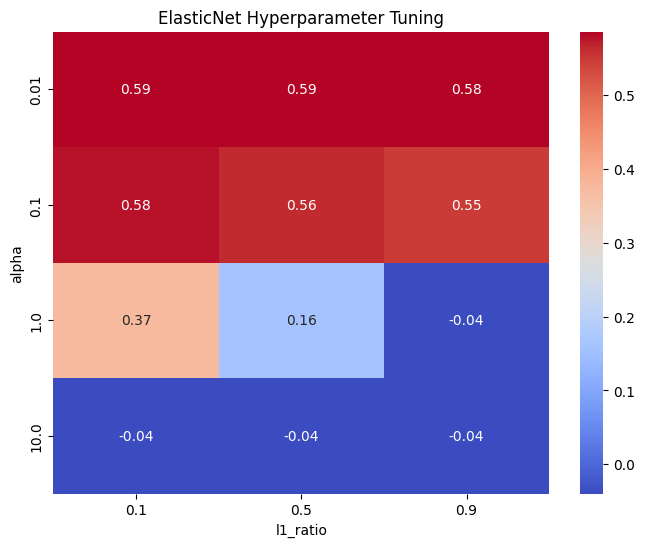

In [67]:


# Define a function to plot RMSE vs R² heatmap
def plot_heatmap(grid_search, param1, param2):
    """
    Plots heatmap of R² scores for different hyperparameter combinations.
    """
    results = pd.DataFrame(grid_search.cv_results_)
    pivot_table = results.pivot(index=f'param_{param1}', columns=f'param_{param2}', values='mean_test_score')
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_table, annot=True, cmap='coolwarm', cbar=True)
    plt.title("ElasticNet Hyperparameter Tuning")
    plt.xlabel(param2)
    plt.ylabel(param1)
    plt.show()

# Define hyperparameter grid
param_grid = {
    "alpha": [0.01, 0.1, 1, 10],  # Regularization strength
    "l1_ratio": [0.1, 0.5, 0.9]   # ElasticNet mixing parameter
}

# Train ElasticNet with GridSearchCV
elastic_net = GridSearchCV(ElasticNet(), param_grid, scoring="r2", cv=5)
elastic_net.fit(X_train_reg, y_train_reg)

# Predict and evaluate
y_pred_reg = elastic_net.best_estimator_.predict(X_test_reg)
r2 = r2_score(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))

print(f"📊 Best ElasticNet Parameters: {elastic_net.best_params_}")
print(f"✅ Regression Performance → R²: {r2:.4f}, RMSE: {rmse:.4f}")

# Plot heatmap
plot_heatmap(elastic_net, "alpha", "l1_ratio")



3B: Train Classification Models (Logistic Regression & k-NN)

Define Function to Generate & Save Plots

In [68]:
def plot_auroc_pr(y_true, y_prob, model_name):
    """
    Generates and saves AUROC and Precision-Recall curves for binary or multiclass classification.
    """
    # Check if binary classification (only two unique values in y_true)
    is_binary = len(np.unique(y_true)) == 2

    if is_binary:
        # Binary AUROC
        roc_auc = roc_auc_score(y_true, y_prob)
        # Compute Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        pr_auc = auc(recall, precision)

        # Plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # AUROC Plot
        ax1.plot([0, 1], [0, 1], linestyle="--", color="gray")
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        ax1.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC = {roc_auc:.2f}')
        ax1.set_xlabel("False Positive Rate")
        ax1.set_ylabel("True Positive Rate")
        ax1.set_title(f"{model_name} - ROC Curve")
        ax1.legend()

        # Precision-Recall Curve
        ax2.plot(recall, precision, color='purple', lw=2, label=f'AUPRC = {pr_auc:.2f}')
        ax2.set_xlabel("Recall")
        ax2.set_ylabel("Precision")
        ax2.set_title(f"{model_name} - Precision-Recall Curve")
        ax2.legend()

    else:
        # Multiclass case (Original code)
        n_classes = y_prob.shape[1]
        roc_auc_per_class = []
        for i in range(n_classes):
            roc_auc_per_class.append(roc_auc_score(y_true == i, y_prob[:, i]))

        macro_auroc = np.mean(roc_auc_per_class)

        precision = dict()
        recall = dict()
        pr_auc = dict()
        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_prob[:, i])
            pr_auc[i] = auc(recall[i], precision[i])

        # Plot AUROC per class
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        ax1.plot(range(n_classes), roc_auc_per_class, marker='o', linestyle='-', color="blue", label="Per-Class AUROC")
        ax1.axhline(macro_auroc, color="red", linestyle="--", label=f"Macro-Average: {macro_auroc:.2f}")
        ax1.set_xticks(range(n_classes))
        ax1.set_xticklabels([f"Class {i}" for i in range(n_classes)])
        ax1.set_ylim(0, 1)
        ax1.set_xlabel("Class")
        ax1.set_ylabel("AUROC")
        ax1.set_title(f"{model_name} - AUROC Per Class")
        ax1.legend()

        # Precision-Recall Curve per class
        for i in range(n_classes):
            ax2.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AUPRC = {pr_auc[i]:.2f})')

        ax2.set_xlabel("Recall")
        ax2.set_ylabel("Precision")
        ax2.set_title(f"{model_name} - Precision-Recall Curve")
        ax2.legend()

    # Save and show plots
    roc_filename = os.path.join(plot_dir, f"{model_name}_AUROC.png")
    pr_filename = os.path.join(plot_dir, f"{model_name}_Precision_Recall_Curve.png")
    plt.savefig(roc_filename)
    plt.savefig(pr_filename)

    print(f"✅ Updated Plots Saved: {roc_filename}, {pr_filename}")
    plt.show()


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\AppData\Local\Progra

✅ Updated Plots Saved: ../Data/Logistic_Regression_AUROC.png, ../Data/Logistic_Regression_Precision_Recall_Curve.png


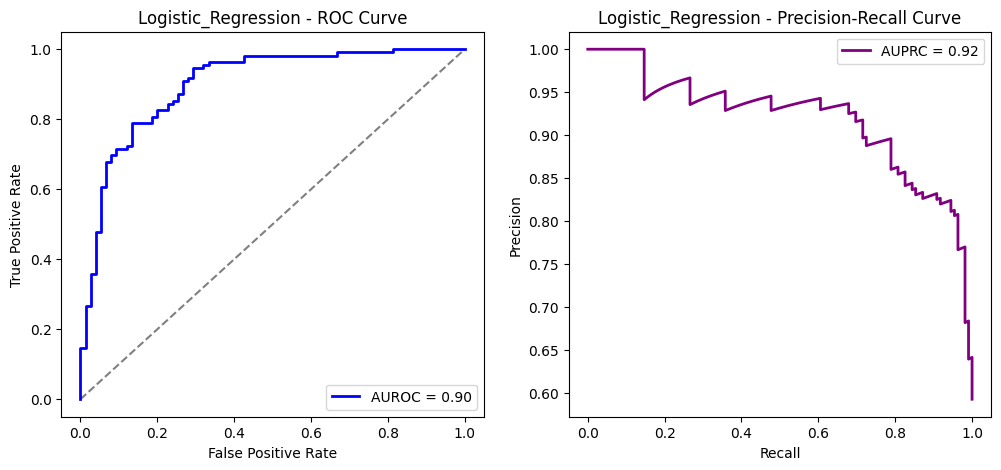

✅ Updated Plots Saved: ../Data/k-NN_Classifier_AUROC.png, ../Data/k-NN_Classifier_Precision_Recall_Curve.png


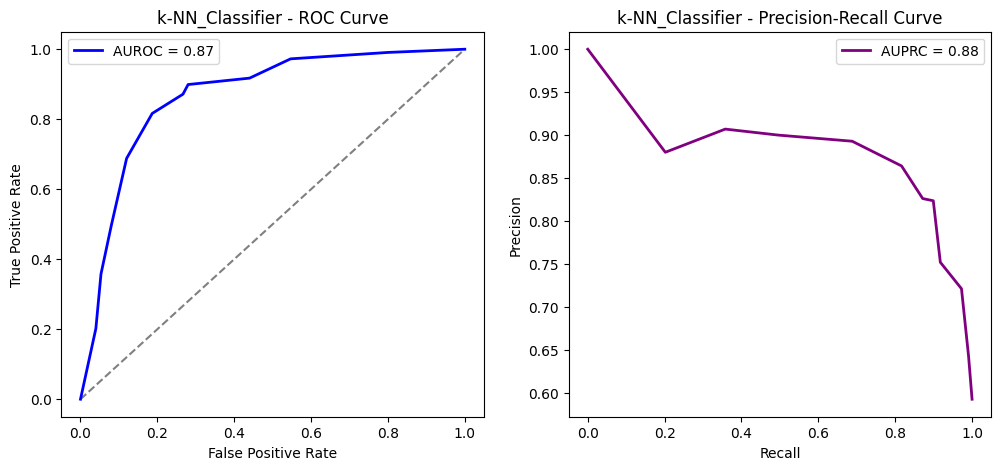

In [69]:
# Convert 'num' into a binary classification target
df["num"] = df["num"].apply(lambda x: 1 if x > 0 else 0)  # 1 = Disease, 0 = No Disease


# Split data 
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, df["num"], test_size=0.2, random_state=42)

# Train Logistic Regression & k-NN
log_reg.fit(X_train_clf, y_train_clf)
knn.fit(X_train_clf, y_train_clf)

# Get probability scores
y_prob_lr = log_reg.best_estimator_.predict_proba(X_test_clf)[:, 1]
y_prob_knn = knn.best_estimator_.predict_proba(X_test_clf)[:, 1]

# Generate updated AUROC & AUPRC plots
plot_auroc_pr(y_test_clf, y_prob_lr, "Logistic_Regression")
plot_auroc_pr(y_test_clf, y_prob_knn, "k-NN_Classifier")


In [70]:


# Compute Binary AUROC
roc_lr = roc_auc_score(y_test_clf, y_prob_lr)
roc_knn = roc_auc_score(y_test_clf, y_prob_knn)

# Compute Binary AUPRC
precision_lr, recall_lr, _ = precision_recall_curve(y_test_clf, y_prob_lr)
pr_auc_lr = auc(recall_lr, precision_lr)

precision_knn, recall_knn, _ = precision_recall_curve(y_test_clf, y_prob_knn)
pr_auc_knn = auc(recall_knn, precision_knn)

# Print Updated AUROC & AUPRC Scores
print(f"📊 Logistic Regression - AUROC: {roc_lr:.4f}, AUPRC: {pr_auc_lr:.4f}")
print(f"📊 k-NN Classifier - AUROC: {roc_knn:.4f}, AUPRC: {pr_auc_knn:.4f}")


📊 Logistic Regression - AUROC: 0.9007, AUPRC: 0.9190
📊 k-NN Classifier - AUROC: 0.8662, AUPRC: 0.8813
